# The art of using t-SNE for single-cell transcriptomics

## Tasic et al. dataset

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import pickle
import scipy
import time
from scipy import sparse

# import tsne
import sys; sys.path.append('/home/localadmin/github/FIt-SNE')
from fast_tsne import fast_tsne

# import my feature selection function and other stuff
import rnaseqTools

# data format
from collections import namedtuple
RNAseqData = namedtuple('RNAseqData', 'counts rpkm genes areas clusters clustergroups '
                                      'clusterColors clusterNames clustergroupNames')

In [2]:
# filename = '../data/allen-visp-alm/mouse_VISp_2018-06-14_exon-matrix.csv'
# counts1, genes1, cells1 = rnaseqTools.sparseload(filename)

# filename = '../data/allen-visp-alm/mouse_ALM_2018-06-14_exon-matrix.csv'
# counts2, genes2, cells2 = rnaseqTools.sparseload(filename)

# counts = sparse.vstack((counts1, counts2), format='csc')

# cells = np.concatenate((cells1, cells2))

# if np.all(genes1==genes2):
#     genes = np.copy(genes1)

# genesDF = pd.read_csv('../data/allen-visp-alm/mouse_VISp_2018-06-14_genes-rows.csv')
# ids     = genesDF['gene_entrez_id'].tolist()
# symbols = genesDF['gene_symbol'].tolist()
# id2symbol = dict(zip(ids, symbols))
# genes = np.array([id2symbol[g] for g in genes])

# clusterInfo = pd.read_csv('../data/allen-visp-alm/sample_heatmap_plot_data.csv')
# goodCells  = clusterInfo['sample_name'].values
# ids        = clusterInfo['cluster_id'].values
# labels     = clusterInfo['cluster_label'].values
# colors     = clusterInfo['cluster_color'].values

# clusterNames  = np.array([labels[ids==i+1][0] for i in range(np.max(ids))])
# clusterColors = np.array([colors[ids==i+1][0] for i in range(np.max(ids))])
# clusters   = np.copy(ids)

# ind = np.array([np.where(cells==c)[0][0] for c in goodCells])
# counts = counts[ind, :]

# areas = (ind < cells1.size).astype(int)

# tasic2018 = RNAseqData(counts=counts, genes=genes, clusters=clusters-1, areas=areas, 
#                        clusterColors=clusterColors, clusterNames = clusterNames,
#                        clustergroups = None, clustergroupNames = None, rpkm = None)

# print(tasic2018.counts.shape)
# print(np.sum(tasic2018.areas==0))
# print(np.sum(tasic2018.areas==1))
# print(np.unique(tasic2018.clusters).size)

# pickle.dump(tasic2018, open('../data/allen-visp-alm/allenData.pickle', 'wb'))

In [2]:
tasic2018 = pickle.load(open('../data/allen-visp-alm/allenData.pickle', 'rb'))
print(tasic2018.counts.shape)

(23822, 45768)


Chosen offset: 6.43


<IPython.core.display.Javascript object>


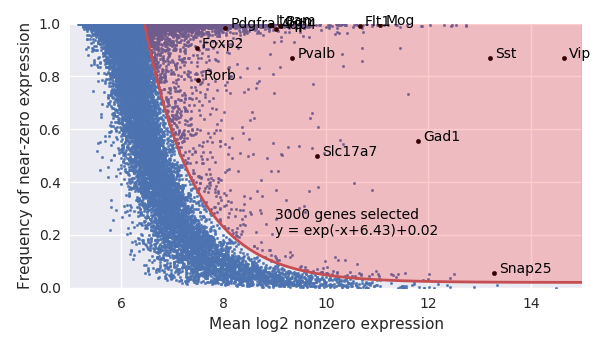

In [3]:
# Feature selection

markers = ['Snap25','Gad1','Slc17a7','Pvalb', 'Sst', 'Vip', 'Aqp4', 
           'Mog', 'Itgam', 'Pdgfra', 'Flt1', 'Bgn', 'Rorb', 'Foxp2']

importantGenesTasic2018 = rnaseqTools.geneSelection(tasic2018.counts, n=3000, threshold=32, 
                                        markers=markers, genes=tasic2018.genes)

## Non t-SNE exploration of the dataset (PCA and MDS)

In [25]:
librarySizes = np.sum(tasic2018.counts, axis=1)
X = np.log2(tasic2018.counts[:, importantGenesTasic2018] / librarySizes * 1e+6 + 1)
X = np.array(X)
X = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:,np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

C = np.max(tasic2018.clusters)
clusterMeans = np.zeros((C, X.shape[1]))
for c in range(C):
    clusterMeans[c,:] = np.mean(X[tasic2018.clusters==c+1,:], axis=0)

from sklearn.manifold import MDS
mds = MDS(2, max_iter=100, n_init=1000, random_state=42)
ZZ = mds.fit_transform(clusterMeans)

firstExcitatoryCluster = np.where(tasic2018.clusterNames=='L2/3 IT VISp Rrad')[0][0] + 1
firstNonneuralCluster = np.where(tasic2018.clusterNames=='Meis2 Adamts19')[0][0] + 1
inhNeurons = tasic2018.clusters < firstExcitatoryCluster
excNeurons = (tasic2018.clusters >= firstExcitatoryCluster) & (tasic2018.clusters < firstNonneuralCluster)
nonNeurons = tasic2018.clusters >= np.where(tasic2018.clusterNames=='Astro Aqp4')[0][0] + 1
subsets = [inhNeurons, excNeurons, nonNeurons]
subsetZs = []
for subsetnum, subset in enumerate(subsets):
    Xsub = np.log2(tasic2018.counts[:, importantGenesTasic2018][subset,:] / 
                   librarySizes[subset] * 1e+6 + 1)  
    Xsub = Xsub - Xsub.mean(axis=0)
    U,s,V = scipy.sparse.linalg.svds(Xsub, k=50)
    U[:,np.sum(V,axis=1)<0] *= -1
    V[np.sum(V,axis=1)<0,:] *= -1
    Xsub = np.dot(U, np.diag(s))
    Xsub = Xsub[:, np.argsort(s)[::-1]]
    Z = X[:,:2].copy()
    Z[subset,:] = Xsub[:,:2]
    Z[~subset,:] = np.nan
    subsetZs.append(Z)

<IPython.core.display.Javascript object>


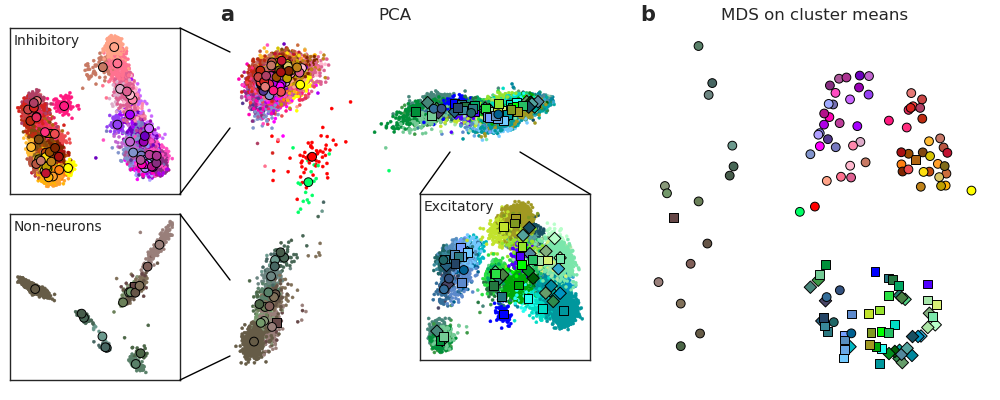

In [13]:
sns.set_style("white")

plt.figure(figsize=(10,4))
plt.axes([.22,0.05,.35,.88])
plotTasic2018(X[:,:2], size=None, title='PCA')

plt.axes([.64,0.05,.35,.88])
fr = np.array([np.mean(tasic2018.areas[tasic2018.clusters==c+1]) 
               for c in np.arange(np.max(tasic2018.clusters))])
plt.scatter(ZZ[fr<.05,0], ZZ[fr<.05,1], color=tasic2018.clusterColors[fr<.05],
            s=40, edgecolor='k', linewidth=.7, marker='D');
plt.scatter(ZZ[fr>.95,0], ZZ[fr>.95,1], color=tasic2018.clusterColors[fr>.95],
            s=40, edgecolor='k', linewidth=.7, marker='s');
plt.scatter(ZZ[(fr<=.95)&(fr>=.05),0], ZZ[(fr<=.95)&(fr>=.05),1], 
            color=tasic2018.clusterColors[(fr<=.95)&(fr>=.05)],
            s=40, edgecolor='k', linewidth=.7, marker='o');
plt.title('MDS on cluster means')
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])
sns.despine(left=True, bottom=True)

subplotPositions = [[.01,.515,.17,.415], [.42,.1,.17,.415], [.01,.05,.17,.415]]
titles = ['Inhibitory', 'Excitatory', 'Non-neurons']
for subsetnum in range(3):
    ax = plt.axes(subplotPositions[subsetnum])
    plotTasic2018(subsetZs[subsetnum][:,:2], size=None)
    for sp in ax.spines:
        ax.spines[sp].set_linewidth(1)
    plt.text(.02,.9, titles[subsetnum], transform = plt.gca().transAxes, fontsize=10)

ax = plt.axes([0,0,1,1])
ax.axis('off')
plt.ylim([0,1])
plt.xlim([0,1])
plt.plot([.18,.23], [.93,.87],   'k', linewidth=1)
plt.plot([.18,.23], [.515,.68], 'k', linewidth=1)
plt.plot([.18,.23], [.05,.11],  'k', linewidth=1)
plt.plot([.18,.23], [.465,.3],  'k', linewidth=1)
plt.plot([.42,.45], [.515,.62],  'k', linewidth=1)
plt.plot([.59,.52], [.515,.62],  'k', linewidth=1)

plt.text(0, 1.02, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=15, fontweight='bold')
plt.text(0, 1.02, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=15, fontweight='bold')
plt.savefig('tsne/pca-mds.png')
plt.savefig('tsne/pca-mds.pdf', dpi=600)

sns.set()

## Perplexity choice and tricks

In [ ]:
# Compute t-SNE in various ways

librarySizes = np.sum(tasic2018.counts, axis=1, keepdims=True)
X = np.log2(tasic2018.counts[:, importantGenesTasic2018] / librarySizes * 1e+6 + 1)  
X = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:,np.sum(V,axis=1)<0] *= -1
V[np.sum(V,axis=1)<0,:] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

# Different perplexities 
perplexities = [5, 10, 50, 100, 500, 1000]
Z_perpl = []
for perpl in perplexities:
    Z_perpl.append(fast_tsne(X, perplexity = perpl, seed = 42))

# Perplexity annealing
Z_annealed_500_50 = fast_tsne(X, perplexity=50, initialization=Z_perpl[-2])

# PCA initialization
PCAinit = X[:,:2]/np.std(X[:,0])*.0001
Z_pca_50 = fast_tsne(X, perplexity=50, initialization=PCAinit)

# Perplexity combinations
perplexity_lists = [[50,500], [5,50,500], [10,50,500], [10,100,500], [10,100,1000]]
Z_perpl_lists = []
for perpl_list in perplexity_lists:
    Z_perpl_lists.append(fast_tsne(X, perplexity = 0, perplexity_list = perpl_list, initialization = PCAinit))

# Annealing after PCA initialization (this works worse: non-neurons get sucked inside)
Z_pca_500 = fast_tsne(X, perplexity=500, initialization=PCAinit)
Z_pca_500_then_50 = fast_tsne(X, perplexity=50, initialization=Z_pca_500)

# More iterations: even though the loss can decrease considerably 
# (0.93 after 1k, 0.78 after 5k), there is little visual improvement
Z_5k_50_500 = fast_tsne(X, perplexity = 0, perplexity_list = [50,500], initialization = PCAinit, max_iter=5000)
Z_5k_5_50_500 = fast_tsne(X, perplexity = 0, perplexity_list = [5, 50,500], initialization = PCAinit, max_iter=5000)

<IPython.core.display.Javascript object>


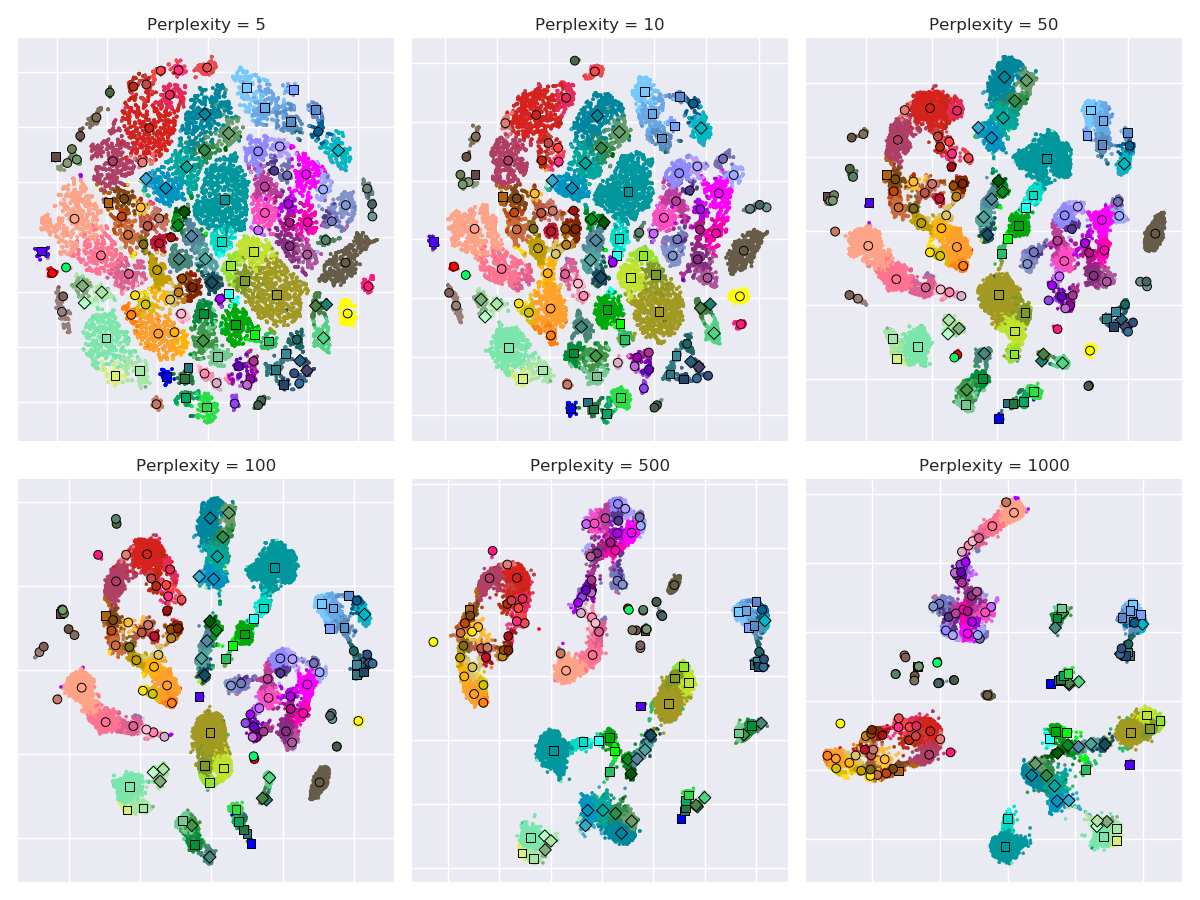

In [659]:
plt.figure(figsize=(12,9))
for i in range(len(Z_perpl)):
    plt.subplot(2,3,i+1)
    plotTasic2018(Z_perpl[i], size=None, title='Perplexity = {}'.format(perplexities[i]))
plt.tight_layout()

<IPython.core.display.Javascript object>


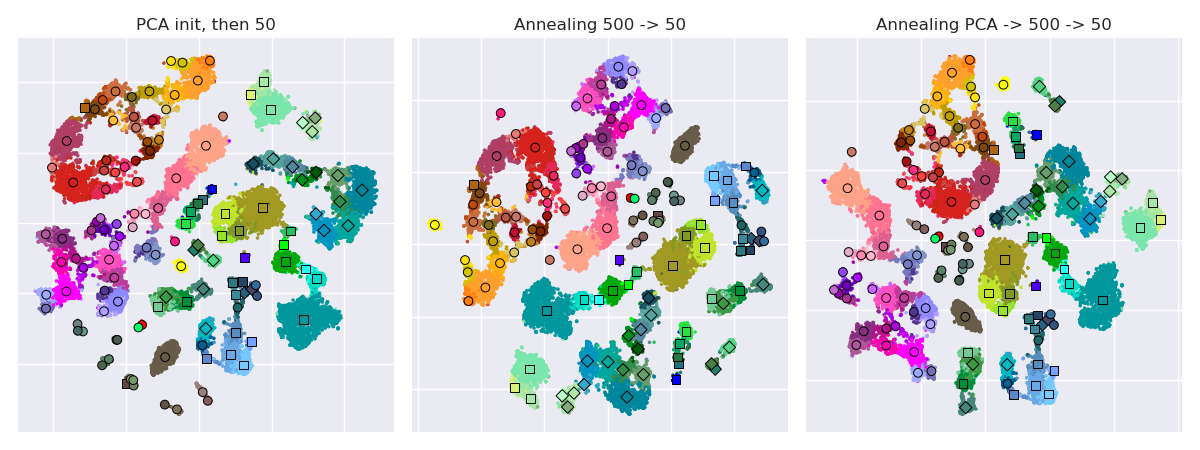

In [662]:
# PCA init and annealing

plt.figure(figsize=(12,4.5))
plt.subplot(131)
plotTasic2018(Z_pca_50, size=None, title='PCA init, then 50')
plt.subplot(132)
plotTasic2018(Z_annealed_500_50, size=None, title='Annealing 500 -> 50')
plt.subplot(133)
plotTasic2018(Z_pca_500_then_50, size=None, title='Annealing PCA -> 500 -> 50')
plt.tight_layout()

<IPython.core.display.Javascript object>


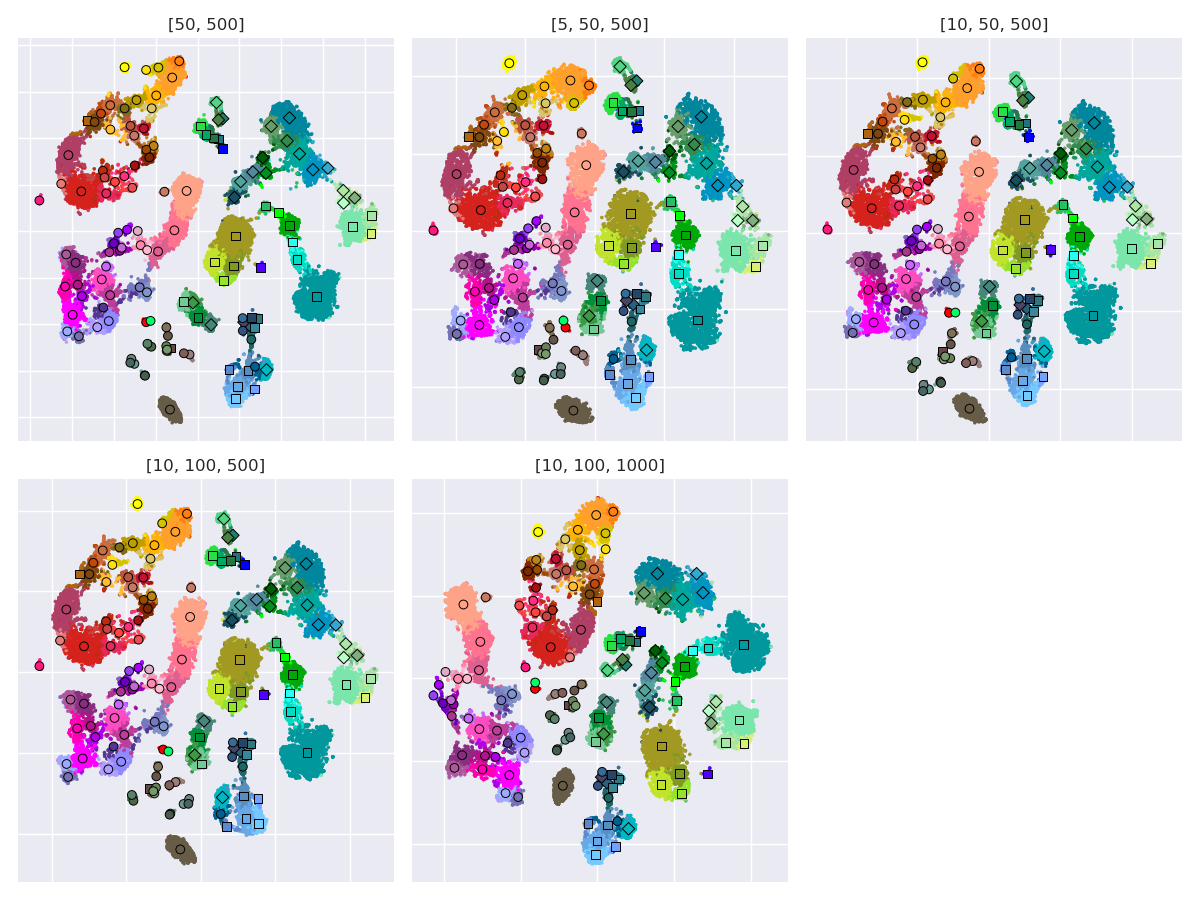

In [664]:
plt.figure(figsize=(12,9))
for i in range(len(Z_perpl_lists)):
    plt.subplot(2,3,i+1)
    plotTasic2018(Z_perpl_lists[i], size=None, title=perplexity_lists[i])
plt.tight_layout()

In [53]:
# Only for the Figure 2

importantGenesTasic2018 = geneScreening(tasic2018.counts, n=3000, threshold=32, plot=False)

librarySizes = np.sum(tasic2018.counts, axis=1, keepdims=True)
X = np.log2(tasic2018.counts[:, importantGenesTasic2018] / librarySizes * 1e+6 + 1)  
X = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:,np.sum(V,axis=1)<0] *= -1
V[np.sum(V,axis=1)<0,:] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

# Different perplexities 
perplexities = [5, 0, 50, 0, 500, 0]
Z_perpl = []
for perpl in perplexities:
    if perpl == 0:
        Z_perpl.append([])
    else:
        Z_perpl.append(fast_tsne(X, perplexity = perpl, seed = 42))

# Perplexity annealing
Z_annealed_500_50 = fast_tsne(X, perplexity=50, initialization=Z_perpl[-2])

# PCA initialization
PCAinit = X[:,:2]/np.std(X[:,0])*.0001
Z_pca_50 = fast_tsne(X, perplexity=50, initialization=PCAinit)

# Perplexity combinations
perplexity_lists = [[50,500]]
Z_perpl_lists = []
for perpl_list in perplexity_lists:
    Z_perpl_lists.append(fast_tsne(X, perplexity = 0, perplexity_list = perpl_list, initialization = PCAinit))

/home/localadmin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


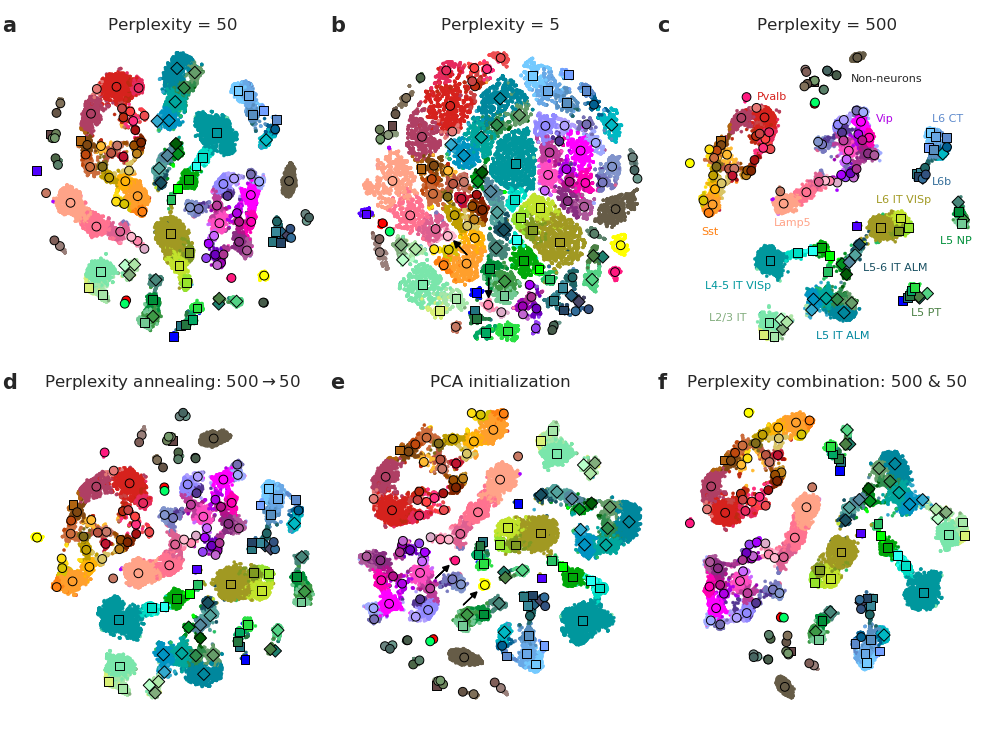

In [136]:
# Figure 2

sns.set_style('white')

#plt.figure(figsize=(12,8.7))
plt.figure(figsize=(10,7.3))
plt.subplot(231)
plotTasic2018(Z_perpl[2], size=None, title='Perplexity = 50')
plt.tight_layout()
plt.subplot(232)
plotTasic2018(Z_perpl[0], size=None, title='Perplexity = 5')

plt.arrow(-16, -26, -4, 4, head_width=3, head_length=3, fc='k', ec='k', linewidth=1)
plt.arrow(-6, -36, 0, -4*np.sqrt(2), head_width=3, head_length=3, fc='k', ec='k', linewidth=1)

plt.subplot(233)
plotTasic2018(Z_perpl[4], size=None, title='Perplexity = 500')

fs = 8
plt.text(-12, -6, 'Lamp5', fontsize=fs,
         color=tasic2018.clusterColors[tasic2018.clusterNames=='Lamp5 Lsp1'][0])
plt.text(12, 17, 'Vip', fontsize=fs,
        color=tasic2018.clusterColors[tasic2018.clusterNames=='Vip Rspo4 Rxfp1 Chat'][0])
plt.text(-29, -8, 'Sst', fontsize=fs,
        color=tasic2018.clusterColors[tasic2018.clusterNames=='Sst Myh8 Fibin'][0])
plt.text(-16, 22, 'Pvalb', fontsize=fs,
        color=tasic2018.clusterColors[tasic2018.clusterNames=='Pvalb Reln Tac1'][0])
plt.text(-27, -27, 'L2/3 IT', fontsize=fs,
        color=tasic2018.clusterColors[tasic2018.clusterNames=='L2/3 IT ALM Sla'][0])
plt.text(-2, -31, 'L5 IT ALM', fontsize=fs,
        color=tasic2018.clusterColors[tasic2018.clusterNames=='L5 IT ALM Tnc'][0])
plt.text(12, -1, 'L6 IT VISp', fontsize=fs,
        color=tasic2018.clusterColors[tasic2018.clusterNames=='L6 IT VISp Penk Col27a1'][0])
plt.text(-28, -20, 'L4-5 IT VISp', fontsize=fs,
        color=tasic2018.clusterColors[tasic2018.clusterNames=='L4 IT VISp Rspo1'][0])
plt.text(9, -16, 'L5-6 IT ALM', fontsize=fs,
        color=tasic2018.clusterColors[tasic2018.clusterNames=='L6 IT ALM Oprk1'][0])
plt.text(20, -26, 'L5 PT', fontsize=fs,
        color=tasic2018.clusterColors[tasic2018.clusterNames=='L5 PT ALM Hpgd'][0])
plt.text(27, -10, 'L5 NP', fontsize=fs,
        color=tasic2018.clusterColors[tasic2018.clusterNames=='L5 NP VISp Trhr Cpne7'][0])
plt.text(25, 17, 'L6 CT', fontsize=fs,
        color=tasic2018.clusterColors[tasic2018.clusterNames=='L6 CT VISp Nxph2 Wls'][0])
plt.text(25, 3, 'L6b', fontsize=fs,
        color=tasic2018.clusterColors[tasic2018.clusterNames=='L6b P2ry12'][0])
plt.text(6, 26, 'Non-neurons', fontsize=fs)

plt.subplot(234)
plotTasic2018(Z_annealed_500_50, size=None, title=r'Perplexity annealing: 500$\:\to\:$50')
plt.subplot(235)
plotTasic2018(Z_pca_50, size=None, title='PCA initialization')

plt.arrow(-19, -11, 3, 3, head_width=2, head_length=2, fc='k', ec='k', linewidth=1)
plt.arrow(-10, -20, 3, 3, head_width=2, head_length=2, fc='k', ec='k', linewidth=1)

plt.subplot(236)
plotTasic2018(Z_perpl_lists[0], size=None, title='Perplexity combination: 500 & 50')

sns.despine(left=True, bottom=True)
labels = 'abcdef'
for i in range(6):
    plt.text(-0.05, 1.02, labels[i], transform = plt.gcf().get_axes()[i].transAxes, fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('tsne/tsne-tuning.png')
plt.savefig('tsne/tsne-tuning.pdf', dpi=600)

sns.set()

In [26]:
# sns.set_style('white')

# plt.figure(figsize=(9,4.5))
# plt.subplot(121)
# plotTasic2018(Z_perpl[2], size=None, title='Default t-SNE')
# plt.subplot(122)
# plotTasic2018(Z_perpl_lists[0], size=None, title='Our t-SNE pipeline')
# sns.despine(left=True, bottom=True)
# plt.tight_layout()
# plt.savefig('tsne/inquiry.pdf')

# sns.set()

## Projecting Cadwell-2016 onto Tasic-2018

Cadwell et al. data files `Data_CortexInterneurons.xlsx` and `IntPhysiologyFinal.mat` can be downloaded from https://github.com/berenslab/patch-seq-rrr/tree/master/cadwellData.

In [4]:
# # Load Cadwell data

# data = pd.read_excel('../data/cadwell-natbiotech/Data_CortexInterneurons.xlsx', sheetname='readcounts')
# cells  = np.array([int(c[5:-1]) for c in data.values[2,2:-5]])
# genes  = np.array([c[1:-1] for c in data.values[4:,1]])
# counts = data.values[4:,2:-5].T.astype('float')

# from scipy import io
# mat = io.loadmat('../data/cadwell-natbiotech/IntPhysiologyFinal.mat')
# types = np.array([mat['cell'][0][n][3][0][0] for n in range(len(mat['cell'][0]))])
# idxs  = np.array([mat['cell'][0][n][0][0][0] for n in range(len(mat['cell'][0]))])

# # Int_44 and Int_45 were removed from the Cadwell et al. due to possible contamination
# types = types[(idxs != 44) & (idxs != 45)]
# idxs  =  idxs[(idxs != 44) & (idxs != 45)]
# counts = counts[[np.where(cells==i)[0][0] for i in idxs], :]

# counts = sparse.csr_matrix(counts)
# cadwell2016 = RNAseqData(counts=counts, genes=genes, clusters=types, 
#                          clusterColors = None, clusterNames = None, clustergroups = None,
#                          clustergroupNames = None, areas=None, rpkm=None)

# pickle.dump(cadwell2016, open('../data/cadwell-natbiotech/cadwell.pickle', 'wb'))

In [27]:
cadwell2016 = pickle.load(open('../data/cadwell-natbiotech/cadwell.pickle', 'rb'))
print(cadwell2016.counts.shape)

(46, 21812)


In [4]:
importantGenesTasic2018 = rnaseqTools.geneSelection(tasic2018.counts, n=3000, threshold=32, plot=False)

librarySizes = np.sum(tasic2018.counts, axis=1)
X = np.log2(tasic2018.counts[:, importantGenesTasic2018] / librarySizes * 1e+6 + 1)  
X = np.array(X)
X = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:,np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

PCAinit = X[:,:2]/np.std(X[:,0])*.0001
Z = fast_tsne(X, perplexity_list=[50,500], initialization=PCAinit)

/home/localadmin/Dropbox (Machens Lab)/Link to rnaseq/rna-seq-tsne/rnaseqTools.py:38: RuntimeWarning: invalid value encountered in true_divide
  meanExpr = np.squeeze(np.array(A.mean(axis=0))) / (1-zeroRate)
/home/localadmin/Dropbox (Machens Lab)/Link to rnaseq/rna-seq-tsne/rnaseqTools.py:51: RuntimeWarning: invalid value encountered in greater
  selected = zeroRate > np.exp(-decay*(meanExpr - xoffset)) + yoffset


Chosen offset: 6.43


In [28]:
pos, pos_boot = rnaseqTools.map_to_tsne(tasic2018.counts[:, importantGenesTasic2018],
                                        tasic2018.genes[importantGenesTasic2018],
                                        cadwell2016.counts, cadwell2016.genes,
                                        Z, bootstrap = True, seed=42)

Using a common set of 2547 genes.
Bootstrapping.................................................................................................... done


<IPython.core.display.Javascript object>


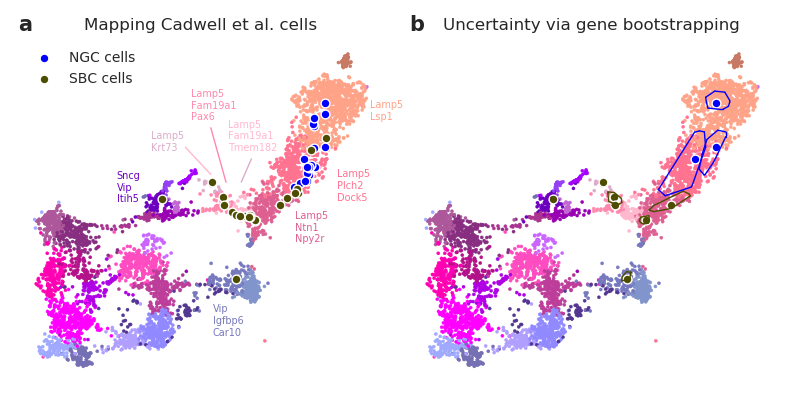

/home/localadmin/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: Invalid value encountered in median for 2 results
  r = func(a, **kwargs)


In [29]:
from scipy.spatial import ConvexHull

Zvip = Z.copy()
Zvip[tasic2018.clusters >= np.where(tasic2018.clusterNames=='Sst Chodl')[0][0],:] = np.nan

sns.set_style('white')

plt.figure(figsize=(8,4))
plt.subplot(121)
rnaseqTools.scatterPlot(Zvip, tasic2018, size=None, showmeans = False, alpha=1, s=5, 
                        title='Mapping Cadwell et al. cells',
                        clusterlabelcolor=None, clusterlabelsplit=True,
                        showclusterlabels = ['Lamp5 Krt73', 'Lamp5 Fam19a1 Pax6', 'Lamp5 Fam19a1 Tmem182',
                                 'Lamp5 Ntn1 Npy2r', 'Lamp5 Plch2 Dock5', 'Lamp5 Lsp1', 'Sncg Vip Itih5', 
                                 'Vip Igfbp6 Car10'],
                        clusterlabeloffsets = [[-6,4], [-3, 11], [-1, 8], [3, -4], 
                                               [4, -4], [4, -2], [-4, 0], [-2, -7]])

plt.plot([-12,-11], [0,3], linewidth=1, color=tasic2018.clusterColors[0])
plt.plot([-13.5,-15], [0,7], linewidth=1, color=tasic2018.clusterColors[1])
plt.plot([-15,-17.5], [1,4.5], linewidth=1, color=tasic2018.clusterColors[2])


a = plt.scatter(pos[cadwell2016.clusters<=2,0], pos[cadwell2016.clusters<=2,1], 
                s=40, color='b', edgecolors='w', linewidth=1)
b = plt.scatter(pos[cadwell2016.clusters>=4,0], pos[cadwell2016.clusters>=4,1], 
                s=40, color=[.3,.3,0], edgecolors='w', linewidth=1)
plt.legend([a,b], ['NGC cells', 'SBC cells'])

plt.subplot(122)
rnaseqTools.scatterPlot(Zvip, tasic2018, size=None, alpha=1, s=5, 
                        showmeans = False, showlabels=False,
                        title='Uncertainty via gene bootstrapping')
for cell in [8, 32, 40, 1, 28, 18, 4, 20, 12, 19]:
    if cadwell2016.clusters[cell]<=2:
        col = 'b'
    else:
        col = [.3,.3,0]
    plt.scatter(pos[cell,0], pos[cell,1], 
            s=40, color=col, edgecolors='w', linewidth=1)
    points = np.squeeze(pos_boot[cell,:,:]).T
    distances = np.sum((points - pos[cell,:])**2, axis=1)
    ind = np.argsort(distances)[:-5]
    points = points[ind,:]
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], color=col, linewidth=1)

sns.despine(left=True, bottom=True)
plt.text(0, 1.02, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=15, fontweight='bold')
plt.text(0, 1.02, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/cadwell-mapping.png')
plt.savefig('figures/cadwell-mapping.pdf', dpi=600)

sns.set()

## Aligning Tasic-2016 and Tasic-2018

In [126]:
# counts = pd.read_csv('../data/tasic-natneuro/genes_counts.csv')
# genes = np.array(counts[counts.columns[0]].tolist())
# counts = counts.values[:,1:].transpose().astype(float)
# counts = sparse.csr_matrix(counts)

# rpkm = pd.read_csv('../data/tasic-natneuro/genes_rpkm.csv')
# rpkm = rpkm.values[:,1:].transpose().astype(float)
# rpkm = sparse.csr_matrix(rpkm)

# cellClassification = pd.read_csv('../data/tasic-natneuro/cell_classification.csv')
# clusters = np.array([int(a[1:]) for a in cellClassification["primary"].tolist()]) - 1

# clusterMetadata = pd.read_csv('../data/tasic-natneuro/cluster_metadata.csv')
# clusterColors = np.array(clusterMetadata["vignette_color"].tolist())
# clusterNames  = np.array(clusterMetadata["vignette_label"].tolist())

# tasic2016 = RNAseqData(counts=counts, rpkm=rpkm, genes=genes, clusters=clusters, 
#                        clusterColors=clusterColors, clusterNames = clusterNames,
#                        clustergroups = None, clustergroupNames = None, areas = None)

# pickle.dump(tasic2016, open('../data/tasic-natneuro/tasic.pickle', 'wb'))

In [7]:
tasic2016 = pickle.load(open('../data/tasic-natneuro/tasic.pickle', 'rb'))

Chosen offset: 8.58


/home/localadmin/Dropbox (Machens Lab)/Link to rnaseq/rna-seq-tsne/rnaseqTools.py:38: RuntimeWarning: invalid value encountered in true_divide
  meanExpr = np.squeeze(np.array(A.mean(axis=0))) / (1-zeroRate)
/home/localadmin/Dropbox (Machens Lab)/Link to rnaseq/rna-seq-tsne/rnaseqTools.py:51: RuntimeWarning: invalid value encountered in greater
  selected = zeroRate > np.exp(-decay*(meanExpr - xoffset)) + yoffset


<IPython.core.display.Javascript object>


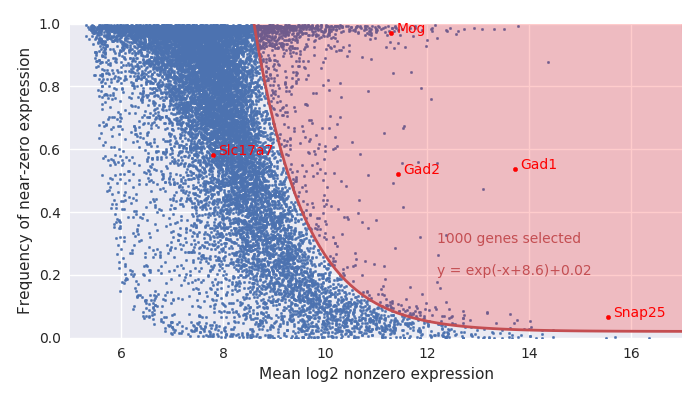

In [14]:
importantGenesTasic2016 = rnaseqTools.geneSelection(tasic2016.counts, n=1000, threshold=32, 
                                        markers=['Snap25', 'Gad2', 'Gad1', 'Slc17a7', 'Mog'], 
                                        genes=tasic2016.genes)

librarySizes = np.sum(tasic2016.counts, axis=1)
X = np.log2(tasic2016.counts[:, importantGenesTasic2016] / librarySizes * 1e+6 + 1)
X = np.array(X)
X = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:,np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

Z_2016 = fast_tsne(X, perplexity = 50, initialization = X[:,:2]/np.std(X[:,0])*.0001)

In [9]:
pos = rnaseqTools.map_to_tsne(tasic2016.counts[:, importantGenesTasic2016],
                              tasic2016.genes[importantGenesTasic2016],
                              tasic2018.counts, tasic2018.genes, Z_2016, knn=10)

Using a common set of 967 genes.
Processing in batches........................ done


In [25]:
visp = np.array([i for i,g in enumerate(tasic2018.clusterNames) if 'ALM' not in g])
indvisp = np.isin(tasic2018.clusters, visp)
print('Excluded {} ALM clusters'.format(tasic2018.clusterNames.size - visp.size))

importantGenesTasic2018_visp = rnaseqTools.geneSelection(tasic2018.counts[indvisp,:], 
                                                         n=3000, threshold=32, plot=False)

librarySizes = np.sum(tasic2018.counts[indvisp], axis=1)
X = np.log2(tasic2018.counts[indvisp,:][:, importantGenesTasic2018_visp] / librarySizes * 1e+6 + 1)  
X = np.array(X)
X = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:,np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

Z_aligned_visp = fast_tsne(X, perplexity_list = [50,500], initialization = pos[indvisp,:])

Z_aligned = np.zeros((indvisp.size, 2)) * np.nan
Z_aligned[indvisp,:] = Z_aligned_visp

pos_visp = pos.copy()
pos_visp[~indvisp,:] = np.nan

Excluded 23 ALM clusters


/home/localadmin/Dropbox (Machens Lab)/Link to rnaseq/rna-seq-tsne/rnaseqTools.py:38: RuntimeWarning: invalid value encountered in true_divide
  meanExpr = np.squeeze(np.array(A.mean(axis=0))) / (1-zeroRate)
/home/localadmin/Dropbox (Machens Lab)/Link to rnaseq/rna-seq-tsne/rnaseqTools.py:51: RuntimeWarning: invalid value encountered in greater
  selected = zeroRate > np.exp(-decay*(meanExpr - xoffset)) + yoffset


Chosen offset: 6.51


<IPython.core.display.Javascript object>


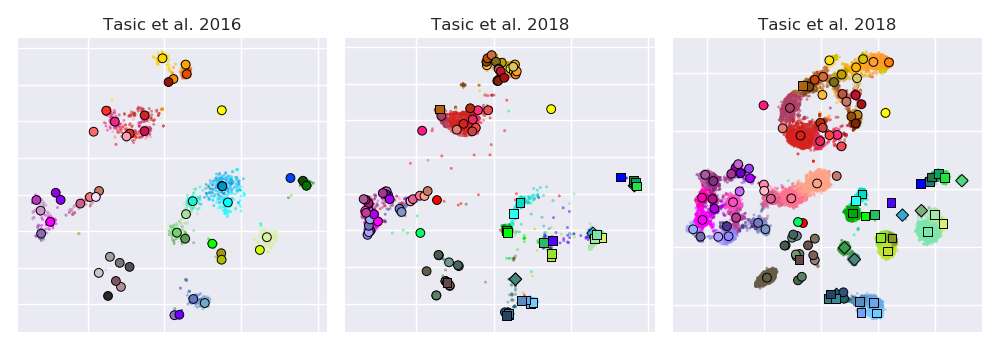

/home/localadmin/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: Invalid value encountered in median for 2 results
  r = func(a, **kwargs)


In [15]:
fr = np.array([np.mean(tasic2018.areas[tasic2018.clusters==c]) for c in range(tasic2018.clusterNames.size)])
markers = ['D' if f<.05 else 's' if f>.95 else 'o' for f in fr]

plt.figure(figsize=(10,3.5))
plt.subplot(131)
rnaseqTools.scatterPlot(Z_2016, tasic2016, showlabels=False, title='Tasic et al. 2016', size=None)
plt.subplot(132)
rnaseqTools.scatterPlot(pos_visp, tasic2018, showlabels=False, title='Tasic et al. 2018', size=None, markers=markers)
plt.subplot(133)
rnaseqTools.scatterPlot(Z_aligned, tasic2018, showlabels=False, title='Tasic et al. 2018', size=None, markers=markers)
plt.tight_layout()

<IPython.core.display.Javascript object>


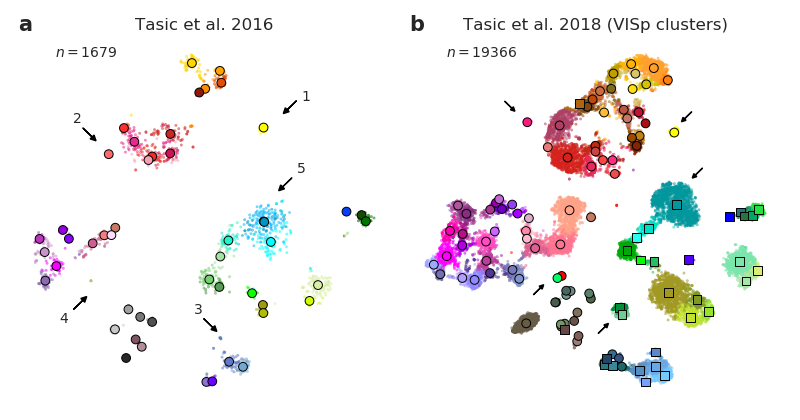

/home/localadmin/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: Invalid value encountered in median for 2 results
  r = func(a, **kwargs)


In [26]:
fr = np.array([np.mean(tasic2018.areas[tasic2018.clusters==c]) for c in range(tasic2018.clusterNames.size)])
markers = ['D' if f<.05 else 's' if f>.95 else 'o' for f in fr]

sns.set_style("white")

plt.figure(figsize=(8,4.2))
plt.subplot(121)
rnaseqTools.scatterPlot(Z_2016, tasic2016, size=None, title='Tasic et al. 2016', showlabels=False)
plt.arrow(-26, -17, 2, 2, head_width=1.2, head_length=1.2, fc='k', ec='k', linewidth=1)
plt.text(-29,-20,'4',fontsize=10)
plt.arrow(-24, 23, 2, -2, head_width=1.2, head_length=1.2, fc='k', ec='k', linewidth=1)
plt.text(-26,24,'2',fontsize=10)
plt.arrow(22, 29, -2, -2, head_width=1.2, head_length=1.2, fc='k', ec='k', linewidth=1)
plt.text(23, 29,'1',fontsize=10)
plt.arrow(21, 12, -2, -2, head_width=1.2, head_length=1.2, fc='k', ec='k', linewidth=1)
plt.text(22,13,'5',fontsize=10)
plt.arrow(2, -19, 2, -2, head_width=1.2, head_length=1.2, fc='k', ec='k', linewidth=1)
plt.text(0,-18,'3',fontsize=10)
plt.text(.1,.95, r'$n={}$'.format(Z_2016.shape[0]), transform=plt.gca().transAxes, fontsize=10)

plt.subplot(122)
rnaseqTools.scatterPlot(Z_aligned, tasic2018, size=None, title='Tasic et al. 2018 (VISp clusters)',
                        markers=markers, showlabels=False)
plt.arrow(-19, -19, 2, 2, head_width=1.2, head_length=1.2, fc='k', ec='k', linewidth=1)
plt.arrow(-27, 36, 2, -2, head_width=1.2, head_length=1.2, fc='k', ec='k', linewidth=1)
plt.arrow(25, 33, -2, -2, head_width=1.2, head_length=1.2, fc='k', ec='k', linewidth=1)
plt.arrow(28, 17, -2, -2, head_width=1.2, head_length=1.2, fc='k', ec='k', linewidth=1)
plt.arrow(-1, -30, 2, 2, head_width=1.2, head_length=1.2, fc='k', ec='k', linewidth=1)
plt.text(.1,.95, r'$n={}$'.format(np.sum(indvisp)), transform=plt.gca().transAxes, fontsize=10)

plt.text(0, 1.02, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=15, fontweight='bold')
plt.text(0, 1.02, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=15, fontweight='bold')
plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.savefig('figures/tasic-vs-tasic.png')
plt.savefig('figures/tasic-vs-tasic.pdf', dpi=600)

sns.set()

## Supplementary figure: feature selection

<IPython.core.display.Javascript object>


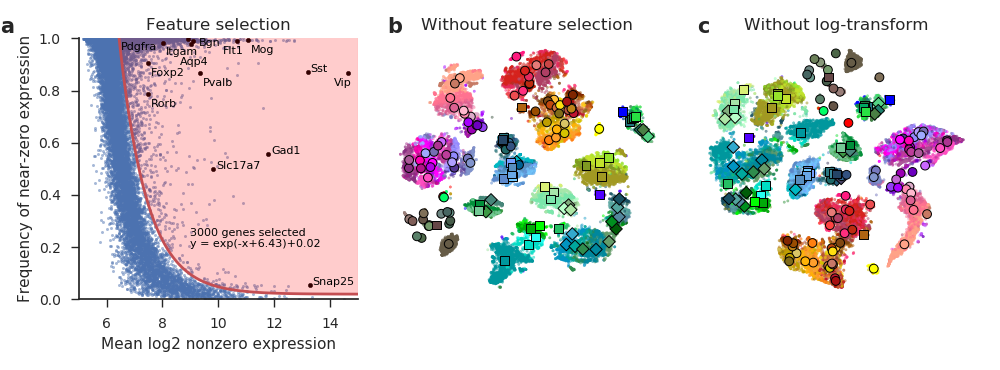

Chosen offset: 6.43


In [24]:
# Supplementary figure showing feature selection and the effects 
# of log-transform and feature selection on t-SNE

librarySizes = np.array(np.sum(tasic2018.counts, axis=1))
X = np.log2(tasic2018.counts / librarySizes * 1e+6 + 1)
X = np.array(X)
X = X - X.mean(axis=0)
U,s,V = scipy.sparse.linalg.svds(X, k=50)
U[:, np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]
PCAinit = X[:,:2] / np.std(X[:,0]) * .0001
Z_noFeatureSelection = fast_tsne(X, perplexity_list=[50,500], initialization=PCAinit)

X = tasic2018.counts[:, importantGenesTasic2018] / librarySizes * 1e+6
X = np.array(X)
X = X - X.mean(axis=0)        
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:, np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]
PCAinit = X[:,:2] / np.std(X[:,0]) * .0001
Z_noLogTransform = fast_tsne(X, perplexity_list=[50,500], initialization=PCAinit)

######

markers = ['Snap25','Gad1','Slc17a7','Pvalb', 'Sst', 'Vip', 'Aqp4', 
           'Mog', 'Itgam', 'Pdgfra', 'Flt1', 'Bgn', 'Rorb', 'Foxp2']

sns.set_style('ticks')
plt.figure(figsize=(10,3.7))
ax1 = plt.subplot(131)
rnaseqTools.geneSelection(tasic2018.counts, n=3000, threshold=32, figsize=None,
              markers=markers, genes=tasic2018.genes,
              markeroffsets=[[0,0], [0,0], [0,0], [0,-.05], [0,0],
                    [-.6,-.05], [-0.5,-.08], [0, -.05], [-.9,-0.06], [-1.6,-0.03],
                    [-.6,-0.05], [0.1,-0.02], [0,-0.05], [0,-0.05]],
              labelsize=8, alpha=.5)
plt.title('Feature selection')

fr = np.array([np.mean(tasic2018.areas[tasic2018.clusters==c]) for c in range(tasic2018.clusterNames.size)])
markers = ['D' if f<.05 else 's' if f>.95 else 'o' for f in fr]

ax2 = plt.subplot(132)
rnaseqTools.scatterPlot(Z_noFeatureSelection, tasic2018, showlabels=False, 
                        title='Without feature selection', size=None, markers=markers)
ax3 = plt.subplot(133)
rnaseqTools.scatterPlot(Z_noLogTransform, tasic2018, showlabels=False, 
                        title='Without log-transform', size=None, markers=markers)
sns.despine(ax=ax1)
sns.despine(ax=ax2, left=True, bottom=True)
sns.despine(ax=ax3, left=True, bottom=True)
ax2.tick_params(which='both', bottom=False, left=False)
ax3.tick_params(which='both', bottom=False, left=False)
plt.tight_layout()
plt.text(-0.28, 1.02, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=15, fontweight='bold')
plt.text(0, 1.02, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=15, fontweight='bold')
plt.text(0, 1.02, 'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=15, fontweight='bold')
plt.savefig('figures/featureSelection.png')
plt.savefig('figures/featureSelection.pdf', dpi=600)
sns.set()

## UMAP (for discussion)

In [5]:
importantGenesTasic2018 = geneScreening(tasic2018.counts, n=3000, threshold=32, plot=False)

librarySizes = np.sum(tasic2018.counts, axis=1, keepdims=True)
X = np.log2(tasic2018.counts[:, importantGenesTasic2018] / librarySizes * 1e+6 + 1)  
X = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:,np.sum(V,axis=1)<0] *= -1
V[np.sum(V,axis=1)<0,:] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

import umap

/home/localadmin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


n_neighbors: This determines the number of neighboring points used in local approximations of manifold structure. Larger values will result in more global structure being preserved at the loss of detailed local structure. In general this parameter should often be in the range 5 to 50, with a choice of 10 to 15 being a sensible default.

min_dist: This controls how tightly the embedding is allowed compress points together. Larger values ensure embedded points are more evenly distributed, while smaller values allow the algorithm to optimise more accurately with regard to local structure. Sensible values are in the range 0.001 to 0.5, with 0.1 being a reasonable default.

<IPython.core.display.Javascript object>


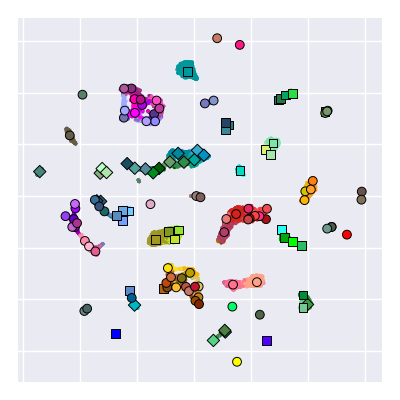

In [7]:
Z = umap.UMAP().fit_transform(X)
plotTasic2018(Z)

<IPython.core.display.Javascript object>


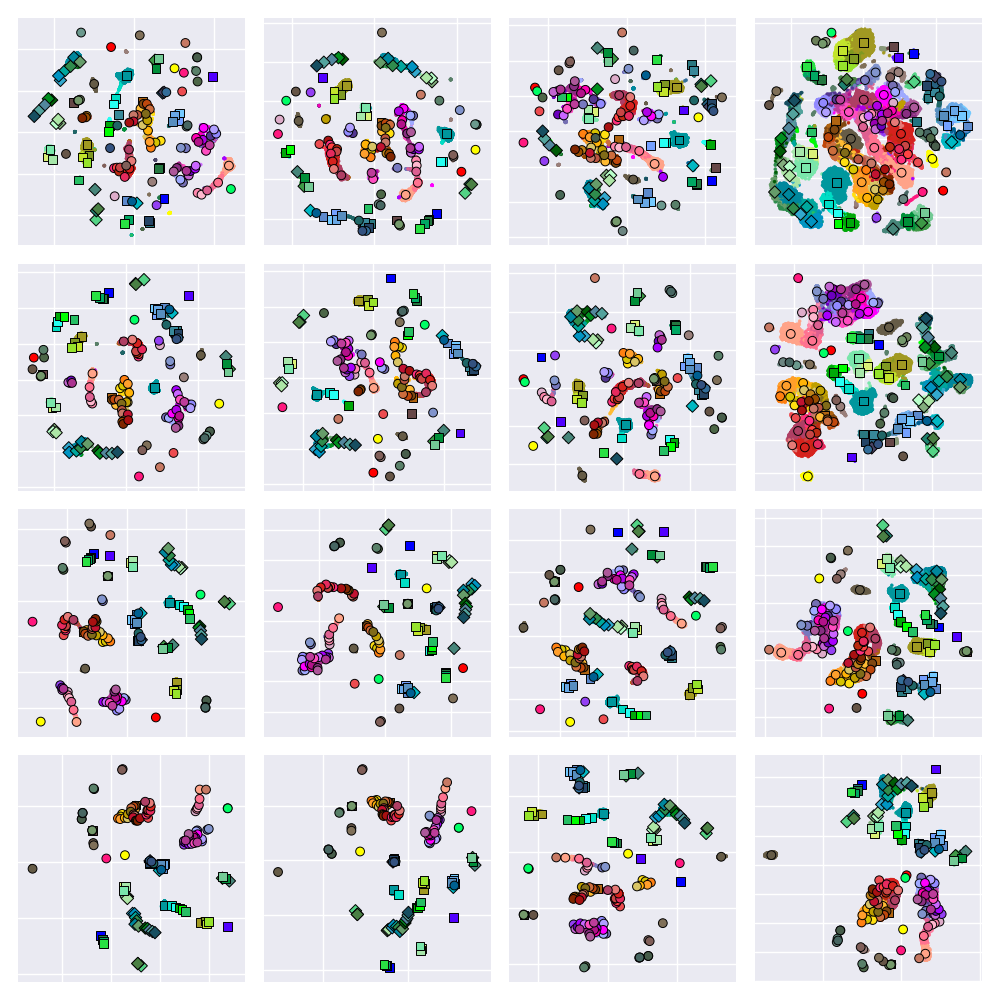

In [11]:
# n_neighbors: This determines the number of neighboring points used in local approximations 
# of manifold structure. Larger values will result in more global structure being preserved 
# at the loss of detailed local structure. In general this parameter should often be in the 
# range 5 to 50, with a choice of 10 to 15 being a sensible default.

# min_dist: This controls how tightly the embedding is allowed compress points together. 
# Larger values ensure embedded points are more evenly distributed, while smaller values allow 
# the algorithm to optimise more accurately with regard to local structure. Sensible values 
# are in the range 0.001 to 0.5, with 0.1 being a reasonable default.

neighb = [5, 10, 50, 100]
dists = [.001, .01, .1, .5]

Zs = []
for i,n in enumerate(neighb):
    for j,d in enumerate(dists):
        Z = umap.UMAP(n_neighbors=n, min_dist=d).fit_transform(X)
        Zs.append(Z)
        
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plotTasic2018(Zs[i], size=None)
plt.tight_layout()

## Further experiments (not shown in the paper)

In [ ]:
# Different approaches to feature selection...

def sparsevar(X, axis=0):
    squaredX = X.copy()
    squaredX.data = squaredX.data**2
    v = np.array(squaredX.mean(axis=axis)) - np.array(X.mean(axis=axis))**2
    squaredX = []
    return np.squeeze(v)

meanExpr = np.squeeze(np.array(tasic2018.counts.mean(axis=0)))
zeroRate = 1 - np.squeeze(np.array(np.mean(tasic2018.counts > 0, axis=0)))
lowExprRate = 1 - np.squeeze(np.array(np.mean(tasic2018.counts > 32, axis=0)))
A = tasic2018.counts.multiply(tasic2018.counts > 32)
A.data = np.log2(A.data)
meanHighExpr = np.squeeze(np.array(A.mean(axis=0))) / (1-lowExprRate)
varExpr = sparsevar(tasic2018.counts)
cv2 = varExpr/meanExpr**2

A = tasic2018.counts.copy()
A.data = np.log2(A.data + 1)
meanlog2p = np.squeeze(np.array(np.mean(A, axis=0)))
varlog2p  = np.squeeze(np.array(sparsevar(A)))
A = []

plt.figure(figsize=(7,7))

plt.subplot(221)
plt.scatter(meanHighExpr, lowExprRate, s=3, alpha=.1)
for g in markers:
    i = np.where(tasic2018.genes==g)[0]
    plt.scatter(meanHighExpr[i], lowExprRate[i], s=10, color='r')
plt.xlabel('Mean log2 non-zero expression')
plt.ylabel('Frequency of near-zero expression')
plt.ylim([0,1])
x = np.arange(5,15,.1)
y = np.exp(-(x - 6.43)) + .02
plt.plot(x, y, color=sns.color_palette()[2], linewidth=1)

plt.subplot(222)
plt.scatter(meanExpr, zeroRate, s=3, alpha=.1)
for g in markers:
    i = np.where(tasic2018.genes==g)[0]
    plt.scatter(meanExpr[i], zeroRate[i], s=10, color='r')
plt.xlabel('Mean expression')
plt.ylabel('Frequency of zero expression')
plt.xscale('log')
plt.ylim([0,1])
plt.xlim([10**-3, 10**6])

plt.subplot(223)
plt.scatter(meanExpr, cv2, s=3, alpha=.1)
for g in markers:
    i = np.where(tasic2018.genes==g)[0]
    plt.scatter(meanExpr[i], cv2[i], s=10, color='r')
plt.xlabel('Mean expression')
plt.ylabel('Coef. of variation (var/mean**2)')
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**-4, 10**6])
plt.ylim([10**-1, 10**5])

plt.subplot(224)
plt.scatter(meanlog2p, varlog2p, s=3, alpha=.1)
for g in markers:
    i = np.where(tasic2018.genes==g)[0]
    plt.scatter(meanlog2p[i], varlog2p[i], s=10, color='r')
plt.xlabel('Mean of log(x+1) expression')
plt.ylabel('Variance of log(x+1) expression')
plt.tight_layout()

In [ ]:
# Dimensionality

librarySizes = np.array(np.sum(tasic2018.counts, axis=1))
X = np.log2(tasic2018.counts[:, importantGenesTasic2018] / librarySizes * 1e+6 + 1)
X = np.array(X)
X = X - X.mean(axis=0)
U, s, V = np.linalg.svd(X, full_matrices=False)
for i in range(X.shape[1]):
    X[:,i] = X[np.random.choice(X.shape[0], size=X.shape[0], replace=False), i]
_, sh, _ = np.linalg.svd(X, full_matrices=False)

plt.figure(figsize=(5,3))
plt.plot(s**2/np.sum(s**2),'-')
plt.plot(sh**2/np.sum(sh**2),'-')
plt.legend(['Actual data', 'Shuffled data'])
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.yscale('log')
plt.tight_layout()